In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

from utils import *
from methods import *
from models import *

In [3]:
# load trained model
model = torch.load('./optimal-models/JV7')
phases = model.phases.clone().detach().numpy()
wrapped_phases = np.array([model.unit_cell.wrap(phase) for phase in phases])

[(<Figure size 640x480 with 2 Axes>, <AxesSubplot:>),
 (<Figure size 640x480 with 2 Axes>, <AxesSubplot:>)]

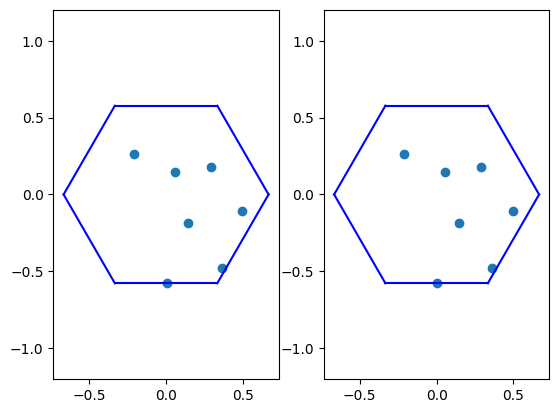

In [5]:
fig, axs = plt.subplots(ncols=2)
axs[0].scatter(*phases.T)
axs[1].scatter(*wrapped_phases.T)
[axs[i].axis('equal') for i in range(len(axs))]
[model.unit_cell.plot(fig,axs[i]) for i in range(len(axs))]